# Data 620 Project 1

Matthew Tillmawitz

For this project we were tasked with three objectives:

1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

The dataset used for this assignment is the [Internet-Industry-Partnerships dataset](https://networkrepository.com/internet-industry-partnerships.php) which represents joint ventures, strategic initiatives, or other partnerships between companies in the internet industry from 1998 to 2001. The nodes in the dataset are split into three groups: infrastructure, content, and commerce representing the primary position of the company in the industry. Analysing this dataset, and particularly different centrality measures, provides interesting insights into the connectedness of different companies and can help identify the key players in the industry. The dataset does not contain any information beyond the nodes, edges, and labels, but in a real-world analysis where additional information such as a temporal component were available analysis of metrics such as centrality could also help identify emerging players in the industry and highlight potential investment opportunities.


In [118]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy import stats

In [119]:
edge_file = "/Users/matttillman/School/data_620/data/internet-industry-partnerships.edges"
label_file = "/Users/matttillman/School/data_620/data/internet-industry-partnerships.node_labels"

In [120]:
G = nx.read_adjlist(edge_file, nodetype=int, delimiter=",")

# Make sure no weirdness with whitespace
with open(label_file, "r") as f:
    labels = [line.strip() for line in f.readlines()]

node_labels = {(index + 1): label for index, label in enumerate(labels)}
for key, value in node_labels.items():
    if value == "1":
        node_labels[key] = "content"
    elif value == "2":
        node_labels[key] = "infrastructure"
    else:
        node_labels[key] = "commerce"

nx.set_node_attributes(G, node_labels, 'label')

In [121]:
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

node_data = []
for node in G.nodes():
    node_data.append({
        'node': node,
        'label': G.nodes()[node]['label'],
        'degree_centrality': degree_centrality[node],
        'eigenvector_centrality': eigenvector_centrality[node],
        'degree': G.degree(node)
    })

df = pd.DataFrame(node_data)

Visualizing the graph is not particularly informative due to the relatively large number of connections between nodes, but a few insights can be gleaned nonetheless. The majority of highly connected nodes appear to be infrastructure companies, indicating a general lack of connectedness from commerce and content companies. We can see a couple exceptions, with several content nodes demonstrating much higher levels of connectivity. These outliers could indicate companies that are particularly well positioned to capitalize on innovations in the industry.

Text(0.5, 1.0, 'Industry Partnership Graph')

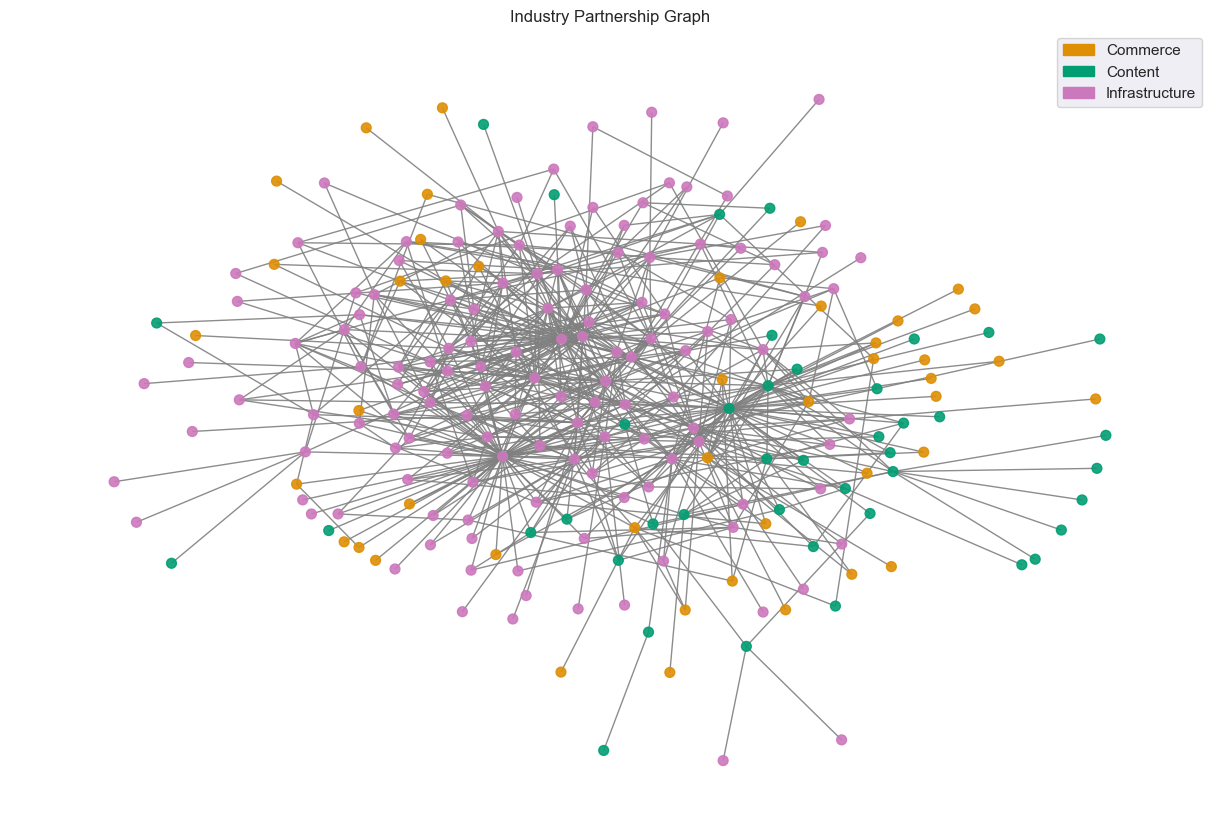

In [122]:
# Colorblind colors at index 1 and 3 are too similar
colors = sns.color_palette("colorblind", 5)

color_map = {
    'commerce': colors[1],
    'content': colors[2], 
    'infrastructure': colors[4]
}

node_to_color = {}
for _,row in df.iterrows():
    node_to_color[row['node']] = color_map[row['label']]

# Create color list in node order for nx to play nice
node_colors = [node_to_color.get(node, colors[0]) for node in G.nodes()]

plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G) 
nx.draw(G, pos, 
        node_color=node_colors,
        node_size=50,
        alpha=0.9,
        edge_color='gray',
        with_labels=False)

legend_elements = [
    mpatches.Patch(color=colors[1], label='Commerce'),
    mpatches.Patch(color=colors[2], label='Content'),
    mpatches.Patch(color=colors[4], label='Infrastructure')
]

plt.legend(handles=legend_elements, loc='upper right')
plt.title("Industry Partnership Graph")

Looking at summary statistics as well as centrality measures gives us a better understanding of the graph as a whole. We can see that that there are significantly more infrastructure nodes than both content and commerce nodes, which are more equal in size. The median and average degree of the infrastructure nodes is also significantly higher, once again demonstrating the greater connectedness of infrastructure companies in general. Of particular interest is the maximum degree centrality of the content and infrastructure nodes, indicating that there are a few select companies with extensive links to other nodes in the graph. We see a similar pattern in the eigenvector centrality, with some content and infrastructure nodes having a high level of connectivity to influential nodes. The potential overlap between these two groups could indicate some of the major power players in the industry.

In [123]:
grouped_stats = df.groupby('label').agg({
    'degree_centrality': ['count', 'median', 'mean', 'std', 'min', 'max'],
    'eigenvector_centrality': ['median', 'mean', 'std', 'min', 'max'],
    'degree': ['median', 'mean', 'std', 'min', 'max']
}).round(4)
grouped_stats

degree_centrality                                          \
                           count  median    mean     std     min     max   
label                                                                      
commerce                      44  0.0092  0.0113  0.0105  0.0046  0.0596   
content                       42  0.0092  0.0218  0.0379  0.0046  0.2294   
infrastructure               133  0.0229  0.0328  0.0370  0.0046  0.2798   

               eigenvector_centrality                                 degree  \
                               median    mean     std     min     max median   
label                                                                          
commerce                       0.0206  0.0233  0.0188  0.0034  0.0900    2.0   
content                        0.0225  0.0312  0.0439  0.0004  0.2647    2.0   
infrastructure                 0.0404  0.0571  0.0556  0.0004  0.3384    5.0   

                                        
                  mean     std min max  
label                                   
commerce        2.4545  2.2972   1  13  
content         4.7619  8.2693   1  50  
infrastructure  7.1579  8.0640   1  61

Before jumping to conclusions it is important to ensure the results are statistically significant and not random noise. The distributions of the different measures, which can be seen further down this document, are not normal so traditional tests such as ANOVA are not applicable. In this case we will use the [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test) and are able to demonstrate that statistically significant differences are present in the distributions of the degree and eigenvector centrality. The p-value indicates the differences are significant and the null hypothesis can be rejected, while the H-statistic of both measures indicates a practically meaningful difference in both measures, although to a slightly lesser degree for the eigenvector centrality.

In [135]:
labels = df['label'].unique()
groups_deg = [df[df['label'] == label]['degree_centrality'] for label in labels]
groups_eig = [df[df['label'] == label]['eigenvector_centrality'] for label in labels]

h_stat_deg, p_val_deg = stats.kruskal(*groups_deg)
h_stat_eig, p_val_eig = stats.kruskal(*groups_eig)

print(f"Degree Centrality Kruskal-Wallis test (across all {len(labels)} labels):")
print(f"  H-statistic: {h_stat_deg:.4f}, P-value: {p_val_deg:.4f}")

print(f"Eigenvector Centrality Kruskal-Wallis test (across all {len(labels)} labels):")
print(f"  H-statistic: {h_stat_eig:.4f}, P-value: {p_val_eig:.4f}")

Degree Centrality Kruskal-Wallis test (across all 3 labels):
  H-statistic: 33.1449, P-value: 0.0000
Eigenvector Centrality Kruskal-Wallis test (across all 3 labels):
  H-statistic: 26.1951, P-value: 0.0000


Looking at distributions of the degree (degree centrality has the exact same distribution and is omitted) and the eigenvector centrality we see a similar pattern of a heavy skew to the lower end of the range for all three types of nodes. For all measures the heavy majority of outliers belong to the infrastructure group, with the commerce companies containing virtually no highly connected nodes and the content companies having only a few. Interestingly, the infrastructure nodes have a much smaller drop off in eigenvector centrality than the other types which indicates a higher degree of connectivity to "influentual" nodes among most of these companies. It appears that the most connected nodes make extensive connections across the population of infrastructure nodes, making these nodes prime vectors for the dissemination of information.

Text(0.5, 1.0, 'Infrastructure Nodes')

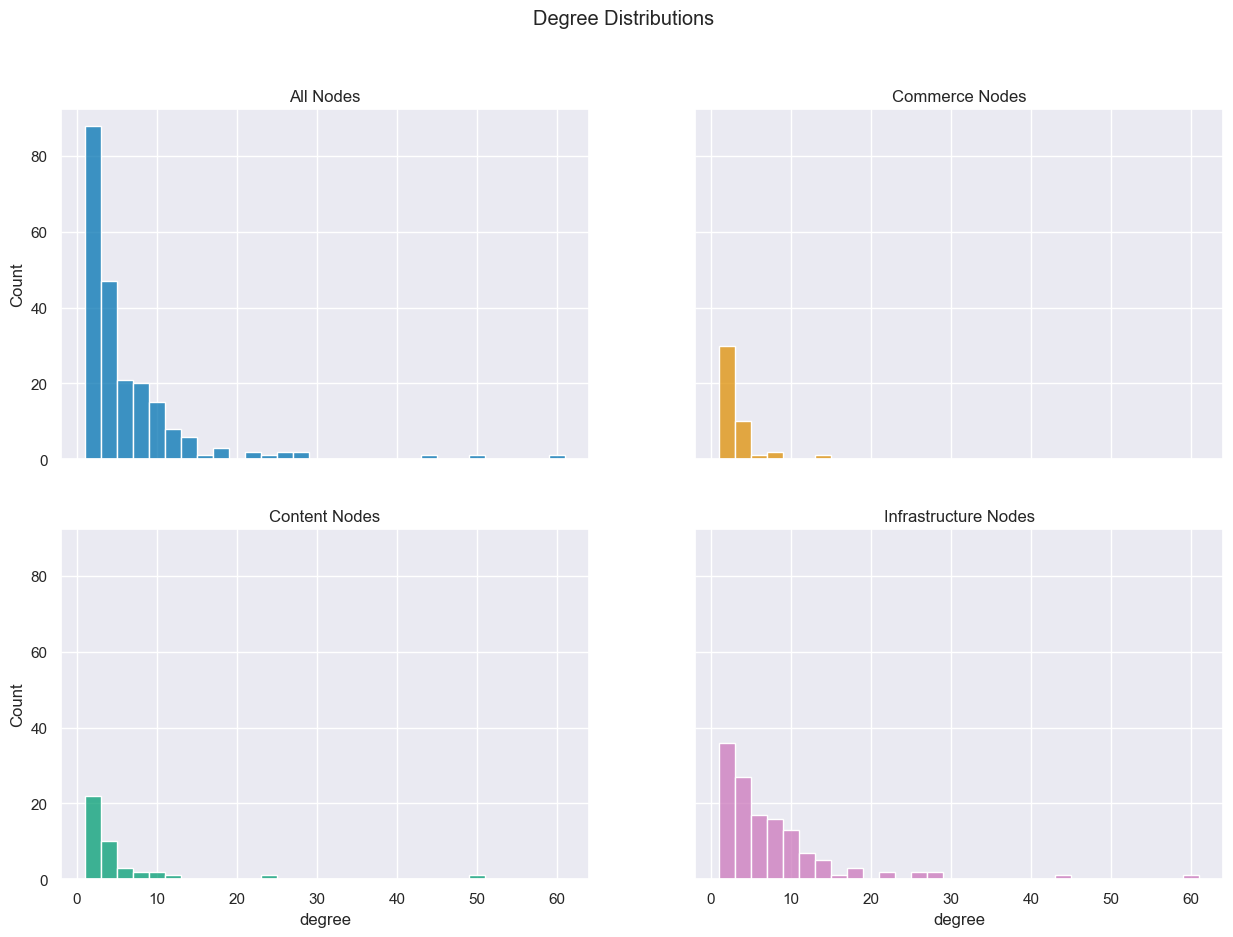

In [125]:
bins = np.histogram_bin_edges(df['degree'], bins='auto')

sns.set_theme()

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("Degree Distributions")

sns.histplot(data=df, x='degree', bins=bins, ax=axes[0,0], color = colors[0])
axes[0,0].set_title("All Nodes")

comm_df = df[df['label'] == "commerce"]
sns.histplot(data=comm_df, x='degree', bins=bins, ax=axes[0,1], color = colors[1])
axes[0,1].set_title("Commerce Nodes")

cont_df = df[df['label'] == "content"]
sns.histplot(data=cont_df, x='degree', bins=bins, ax=axes[1,0], color = colors[2])
axes[1,0].set_title("Content Nodes")

infr_df = df[df['label'] == "infrastructure"]
sns.histplot(data=infr_df, x='degree', bins=bins, ax=axes[1,1], color = colors[4])
axes[1,1].set_title("Infrastructure Nodes")


Text(0.5, 1.0, 'Infrastructure Nodes')

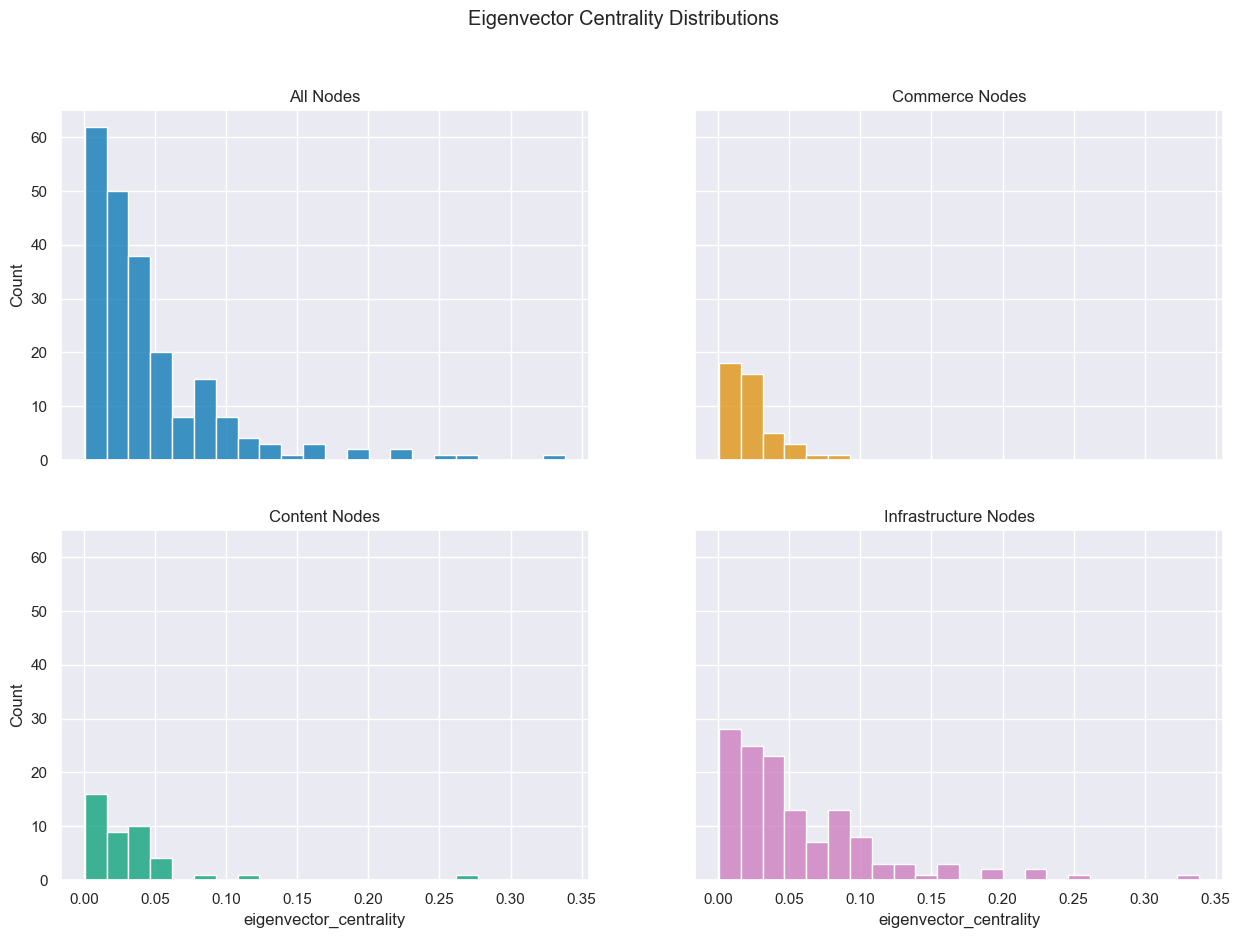

In [126]:
bins = np.histogram_bin_edges(df['eigenvector_centrality'], bins='auto')

sns.set_theme()

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("Eigenvector Centrality Distributions")

sns.histplot(data=df, x='eigenvector_centrality', bins=bins, ax=axes[0,0], color = colors[0])
axes[0,0].set_title("All Nodes")

sns.histplot(data=comm_df, x='eigenvector_centrality', bins=bins, ax=axes[0,1], color = colors[1])
axes[0,1].set_title("Commerce Nodes")

sns.histplot(data=cont_df, x='eigenvector_centrality', bins=bins, ax=axes[1,0], color = colors[2])
axes[1,0].set_title("Content Nodes")

sns.histplot(data=infr_df, x='eigenvector_centrality', bins=bins, ax=axes[1,1], color = colors[4])
axes[1,1].set_title("Infrastructure Nodes")

Plotting degree vs. eigenvector centrality reveals no interesting outliers, with both measures highly correlated with each other across all node types.

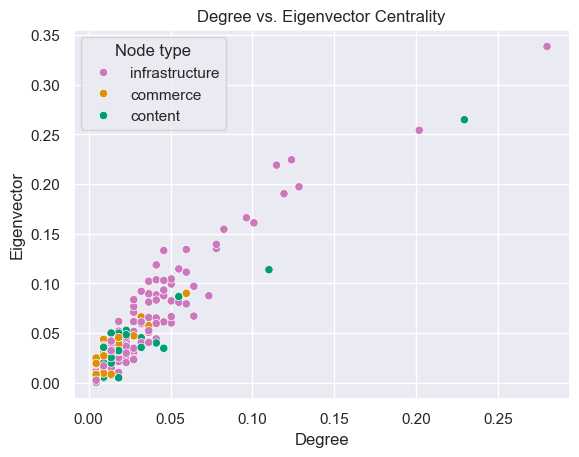

In [127]:
sns.scatterplot(data=df, x='degree_centrality', y='eigenvector_centrality', hue='label', palette=color_map)
plt.legend(title="Node type")
plt.title('Degree vs. Eigenvector Centrality')
plt.xlabel('Degree')
plt.ylabel('Eigenvector')
plt.show()

Looking at the top nodes by both degree and eigenvector centrality, we unsurprisingly see significant overlap given what we know from our analysis already. While the top three companies are identical, the only companies that do not appear on both lists are 4 and 60. This indicates that the major players in the space are the biggest players, with a large number of partnerships resulting in a greater level of connectivity to the influential players in the network. Nodes 4 and 60 could be of interest as emerging players in the space, especially node 60 as the dropoff in degree centrality is much more significant than the dropoff in eigenvector centrality. Node 60 has been able to achieve a much higher ratio of connections to influential companies than others in the sample and as a result could be better positioned to notice and act on new innovations in the space. The better signal to noise ratio in its connections could result in better resource allocation and an overall more efficient partnership network that gives the majority of the benefit of the more connected companies without the additional expense.

In [128]:
n = 10
top_degree = df.nlargest(n, 'degree_centrality')
top_degree[['node', 'label', 'degree_centrality']].style.hide(axis='index')

node,label,degree_centrality
3,infrastructure,0.279817
1,content,0.229358
6,infrastructure,0.201835
5,infrastructure,0.128440
35,infrastructure,0.123853
2,infrastructure,0.119266
49,infrastructure,0.114679
4,content,0.110092
34,infrastructure,0.100917
63,infrastructure,0.096330


In [129]:
top_eigen = df.nlargest(n, 'eigenvector_centrality')
top_eigen[['node', 'label', 'eigenvector_centrality']].style.hide(axis='index')

node,label,eigenvector_centrality
3,infrastructure,0.338433
1,content,0.264728
6,infrastructure,0.254101
35,infrastructure,0.224390
49,infrastructure,0.219028
5,infrastructure,0.197219
2,infrastructure,0.190251
63,infrastructure,0.166051
34,infrastructure,0.160947
60,infrastructure,0.154533
